# 1. 权重衰退

① 权重衰退是常见的处理过拟合的一种方法。

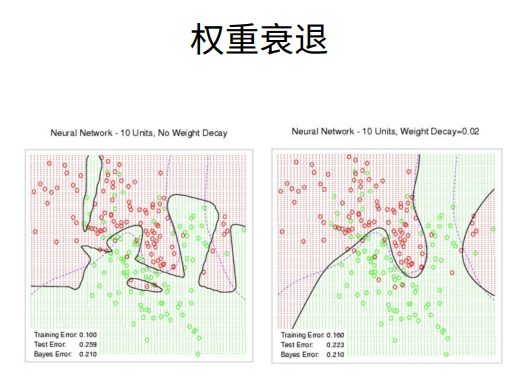

② 把模型容量控制比较小有两种方法，方法一：模型控制的比较小，使得模型中参数比较少。方法二：控制参数选择范围来控制参数容量。

③ 如下图所示，w向量中每一个元素的值都小于θ的根号。

④ 约束就是正则项。每个特征的权重都大会导致模型复杂，从而导致过拟合。控制权重矩阵范数可以使得减少一些特征的权重，甚至使他们权重为0，从而导致模型简单，减轻过拟合。

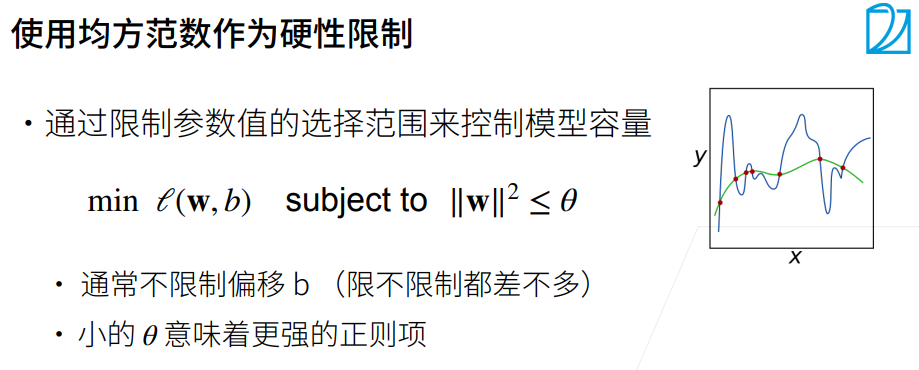

⑤ λ是一个平滑的，不像以前的硬性限制。

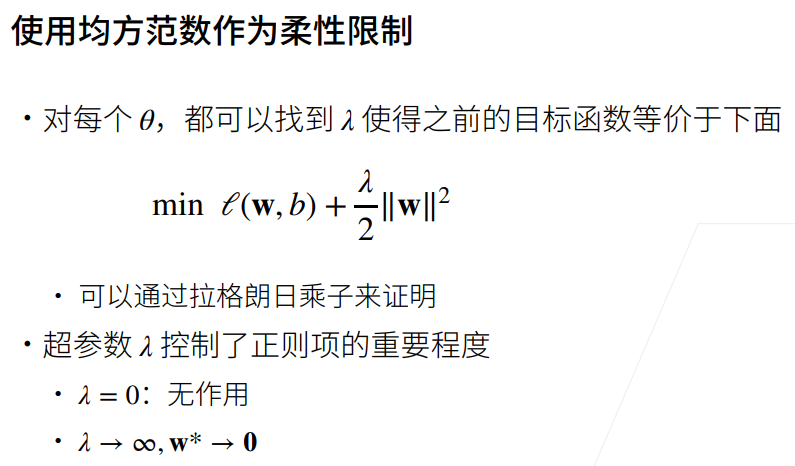

⑥ 拉格朗日乘子法原本是用于解决约束条件下的多元函数极值问题。举例，求f(x,y)的最小值，但是有约束C(x,y) = 0。乘子法给的一般思路是，构造一个新的函数g(x,y,λ) = f(x,y) +λC(x,y)，当同时满足g'x = g'y = 0时，函数取到最小值。这件结论的几何含义是，当f(x,y)与C(x,y)的等高线相切时，取到最小值。

⑦ 具体到机器学习这里，C(x,y) = w^2 -θ。所以视频中的黄色圆圈，代表不同θ下的约束条件。θ越小，则最终的parameter离原点越近。

① 绿色的线就是原始损失函数l的等高线，优化原始损失l的最优解(波浪号即最优解)在中心位置。

② 当原始损失加入二分之λ的项后，这个项是一个二次项，假如w就两个值，x1(横轴)、x2(纵轴)，那么在图上这个二次项的损失以原点为中心的等高线为橙色的图所示。所以合并后的损失为绿色的和黄色的线加一起的损失。

③ 当加上损失项后，可以知道原来最优解对应的二次项的损失特别大，因此原来的最优解不是加上二次项后的公式的最优解了。若沿着橙色的方向走，原有l损失值会大一些，但是二次项罚的损失会变小，当拉到平衡点以内时，惩罚项减少的值不足以原有l损失增大的值，这样w * 就是加惩罚项后的最优解。


④ 损失函数加上正则项成为目标函数，目标函数最优解不是损失函数最优解。正则项就是防止达到损失函数最优导致过拟合，把损失函数最优点往外拉一拉。鼓励权重分散，将所有额特征运用起来，而不是依赖其中的少数特征，并且权重分散的话它的内积就小一些。

⑤ l2正则项会对大数值的权值进行惩罚。

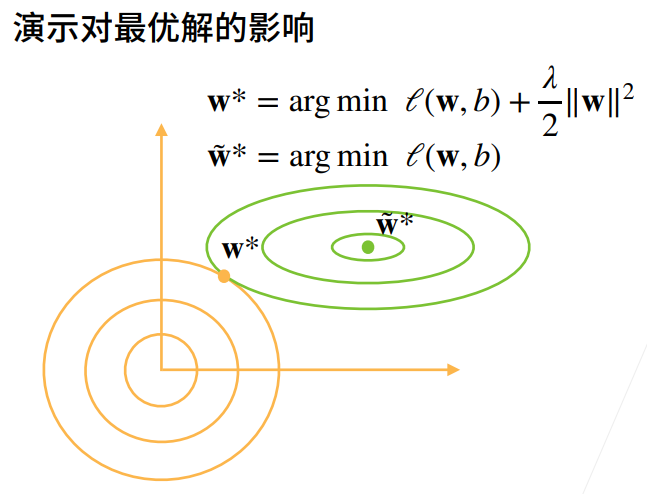

① 相对原来的权重更新，再减去一个值后，使得这个权重更进一步减小，这样会导致这个权重所占的比例进一步减小。

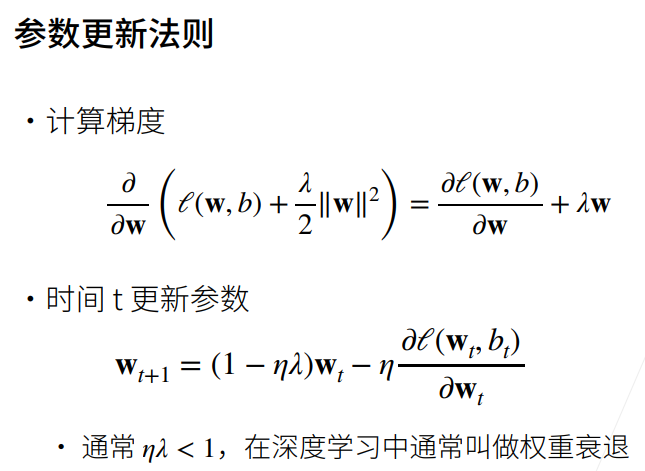

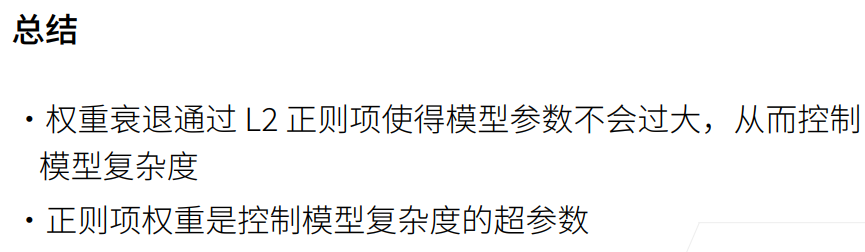

# 2. 权重衰退（使用自定义）

① 权重衰退是最广泛使用的正则化的技术之一。

② 像以前一样生成一些数据：$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5 # 数据越简单，模型越复杂，越容易过拟合。num_inputs为特征维度
true_w, true_b = torch.ones((num_inputs,1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 生成人工数据集
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# 初始化模型参数
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# 定义训练函数
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])                   
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X),y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if(epoch+1) % 5 == 0:
            if(epoch+1) % 5 ==0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是',torch.norm(w).item()) 

In [2]:
help(d2l.synthetic_data) # 查看函数用法

Help on function synthetic_data in module d2l.torch:

synthetic_data(w, b, num_examples)
    Generate y = Xw + b + noise.



w的L2范数是 12.988242149353027


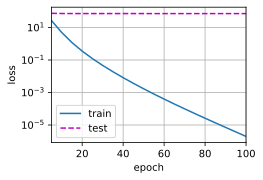

In [3]:
# 忽略正则化直接训练
train(lambd=0)  # 训练集小，过拟合，测试集损失不下降

w的L2范数是 0.336843341588974


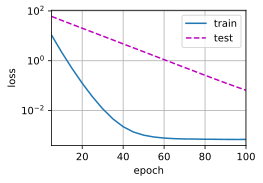

In [4]:
# 使用权重衰退
train(lambd=3)

# 3. 权重衰退（使用框架）

In [5]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{"params":net[0].weight,"weight_decay":wd},{"params":net[0].bias}],lr=lr) # 惩罚项既可以写在目标函数里面，也可以写在训练算法里面，每一次在更新之前把当前的w乘以衰退因子weight_decay                     
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])                   
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X),y)
            l.backward()
            trainer.step()
            if(epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是',net[0].weight.norm().item()) 

w的L2范数是 13.26711368560791


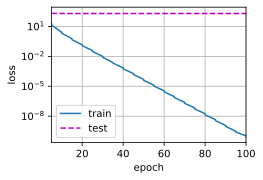

In [6]:
# 这些图看起来和我们从零开始实现权重衰减时的图相同
train_concise(0)

w的L2范数是 0.40912479162216187


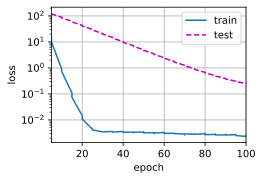

In [7]:
train_concise(3)